In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("bookinghistory.csv", low_memory=False)

In [3]:
df.dropna(subset=['battery_level_at_start','battery_level_at_end'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df.drop(['id', 'bookind_id', 'distance', 'driver_login', 'start_location', 'end_location', 'trip_fare', 'car_group', 'start_zone_name', 'end_zone_name', 'booking_end', 'cp__end', 'cp__start', 'customer_id', 'ignore_relocation_bonus', 'associated_pfm', 'not_invoiced', 'associated_pfr', 'already_invoiced', 'last_update', 'rating', 'car_histoy_match', 'rating_description', 'notif_booking_finished_no_pfr', 'notif_booking_ongoing_no_reservation', 'pk_driver', 'reason_for_no_pfr', 'bonus_malus', 'account', 'car_history_match', 'otoqi_reference', 'city'], axis=1, inplace = True)


### Sort dataframe by date & delta battery column

In [5]:
df['start_date_time']= pd.to_datetime(df['booking_start_date__date'].astype(str), infer_datetime_format=True)
df['end_date_time']= pd.to_datetime(df['booking_end_date__date'].astype(str), infer_datetime_format=True)

In [6]:
df = df.sort_values(by="start_date_time")

In [7]:
df = df.drop_duplicates(subset=['booking_id'], keep='first')

In [8]:
df["charging"] = (df['battery_level_at_end']-df['battery_level_at_start']>1)

In [9]:
df['mileage_end'] = df[["mileage_end", "mileage_start"]].max(axis=1)

### Remove bookings with no change of battery

In [10]:
df['battery_level_at_end'] = pd.to_numeric(df['battery_level_at_end']).astype(int)
df['battery_level_at_start'] = pd.to_numeric(df['battery_level_at_start']).astype(int)

In [11]:
df['delta'] = df['battery_level_at_end']-df['battery_level_at_start']

In [12]:
df['battery_changed'] = (df['battery_level_at_end']-df['battery_level_at_start']!=0)

In [13]:
# df = df[df['battery_changed']==True]

In [14]:
df.drop(['battery_changed'], axis=1, inplace = True)

## Get total distance in bookings

In [15]:
df['month'] = df['start_date_time'].dt.month
month_dict = {2:"Février", 3: "Mars", 4:"Avril", 5: "Mai", 6: "Juin"}
df['month'] = df['month'].map(month_dict)

In [16]:
df['car_model'] = df['car_model'].replace({'Zoe': 'ZOE'})

### Utils

In [17]:
def getSessions(dataframe):
    """
        Returns charging sessions for input dataframe with only one plate number
    """
    dataframe.reset_index(drop=True, inplace=True)
    plate = dataframe.loc[0, 'plate_number']
    model = dataframe.loc[0, 'car_model']
    dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
    dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
    dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
    dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
    dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
    for index in range(len(dataframe)):
        if dataframe.loc[index, 'battery_drop']/(dataframe.loc[index, 'delta_hours']+1) > 5:
            dataframe.loc[index, 'battery_level_at_start'] = dataframe.loc[index, 'last_end_battery']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']
        if (dataframe.loc[index, 'battery_level_at_start'] - dataframe.loc[index, 'battery_level_at_end'])/(dataframe.loc[index, 'duration']+1)>30:
            dataframe.loc[index, 'battery_level_at_end'] = dataframe.loc[index, 'battery_level_at_start']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']

    
    dataframe.reset_index(drop=True, inplace=True)
    dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
    dataframe['was_charging']=(dataframe['battery_level_at_start']-dataframe['last_end_battery']>0)
    dataframe["charging"] = (dataframe['battery_level_at_end']-dataframe['battery_level_at_start']>1)
    charging_sessions = []
    index = 0
    current_start = 0
    start = ""
    start_battery = 0
    current_last = 0
    open_booking = False
    while index < len(dataframe) :
        if open_booking: # car was charging
            if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                open_booking = False
                if dataframe.loc[index, 'was_charging']:
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
                else :
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index-1, 'end_date_time'], start_battery, dataframe.loc[current_last, 'battery_level_at_end'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
                
            else : # car is still charging
                current_last = index
        else : # car wasn't charging
            if dataframe.loc[index, 'was_charging']: # the car was charged since last booking
                open_booking = True
                current_start = index-1
                start = 'end_'
                current_last = index
                start_battery = dataframe.loc[current_start, 'battery_level_at_end']
                if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                    open_booking = False
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
            else :
                if dataframe.loc[index, 'charging']:
                    open_booking = True
                    current_start = index
                    start = "start_"
                    current_last = index
                    start_battery = dataframe.loc[index, 'battery_level_at_start']
                
        index += 1
    return charging_sessions

In [18]:
plates = df.plate_number.unique()
plate = plates[0]

In [19]:
dataframe = df[df['plate_number']==plate]

In [20]:
sessions = []
for plate in plates :
    dataframe = df[df['plate_number']==plate]
    sessions += getSessions(dataframe)
    
sessions_df = pd.DataFrame(sessions, columns = ['plate_number', 'model', 'start_date', 'end_date', 'start_battery', 'end_battery', 'adress', 'driver','mileage'])

In [21]:
sessions_df

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage
0,FB-386-YK,ZOE,2022-03-30 00:37:22,2022-03-30 11:05:04,12.0,13.0,"Quai de Clichy, 92110 Clichy, France",Client,15929.0
1,FB-386-YK,ZOE,2022-03-30 11:30:13,2022-03-30 13:18:19,9.0,85.0,"15 Av. Charles de Gaulle, 92100 Boulogne-Billa...",Van Huy NGUYEN,15945.0
2,FB-386-YK,ZOE,2022-04-04 23:47:56,2022-04-05 08:56:17,72.0,73.0,"9 Rue Franquet, 75015 Paris, France",Client,15967.0
3,FB-386-YK,ZOE,2022-04-06 23:58:21,2022-04-07 12:18:00,49.0,50.0,"4 Rue dOlivet, 75007 Paris, France",Client,16019.0
4,FB-386-YK,ZOE,2022-04-07 18:31:00,2022-04-08 15:39:00,49.0,50.0,"4 Rue dOlivet, 75007 Paris, France",Client,16019.0
...,...,...,...,...,...,...,...,...,...
8618,GB-945-JX,Spring,2022-05-29 00:59:00,2022-05-29 02:25:00,6.0,100.0,"4 Rue Christine de Pisan, 75017 Paris, France",hicham boulahtit,2276.0
8619,FZ-866-RF,Spring,2022-05-24 12:23:00,2022-05-25 17:29:00,4.0,57.0,"28 Rue Yves Kermen, 92100 Boulogne-Billancourt...",Armand LEVEQUE,3040.0
8620,FZ-866-RF,Spring,2022-05-25 17:32:00,2022-05-26 16:03:00,57.0,58.0,"18 Rue Yves Kermen, 92100 Boulogne-Billancourt...",florian arnault,3040.0
8621,FZ-866-RF,Spring,2022-05-27 16:21:00,2022-05-27 18:02:00,11.0,100.0,15 Rue Censier Parking du jardin des plantes A...,Alexandre Makunga,3131.0


In [22]:
sessions_df['delta'] = (sessions_df['end_battery']-sessions_df['start_battery'])
sessions_df = sessions_df[sessions_df['delta'] > 3]
sessions_df['month'] = sessions_df['start_date'].dt.month
month_dict = {2:"Février", 3: "Mars", 4:"Avril", 5: "Mai", 6: "Juin"}
sessions_df['month'] = sessions_df['month'].map(month_dict)
sessions_df['date0'] = pd.to_datetime([datetime.date(year=2022, month=1, day=1) for x in sessions_df.iterrows()])
sessions_df['day']=(sessions_df['start_date']-sessions_df['date0']).dt.days+1
sessions_df['created_id']=sessions_df['plate_number']+sessions_df['driver']+sessions_df['day'].astype(str)
sessions_df.drop(['date0'], axis=1, inplace=True)

In [23]:
sessions_df['last_mileage'] = sessions_df['mileage'].shift(1)
sessions_df['last_plate'] = sessions_df['plate_number'].shift(1)
sessions_df['distance'] = sessions_df['mileage'] - sessions_df['last_mileage']

In [24]:
sessions_df.loc[sessions_df['last_plate']!=sessions_df['plate_number'], 'distance'] = 0

In [25]:
print(len(sessions_df[sessions_df['model']=="Spring"][sessions_df['distance']>230]))

23


In [26]:
print(len(sessions_df[sessions_df['model']=="ZOE"][sessions_df['distance']>395]))

8


In [28]:
zoe_percent = sessions_df[sessions_df['model']=='ZOE'][sessions_df['month']=='Mai']['delta'].sum()
spring_percent = sessions_df[sessions_df['model']=='Spring'][sessions_df['month']=='Mai']['delta'].sum()

In [29]:
zoe_kwh = zoe_percent*40/100
spring_kwh = spring_percent*27/100

In [30]:
print(zoe_kwh, spring_kwh)

21692.4 28044.09


In [31]:
print(zoe_kwh+spring_kwh)

49736.490000000005


In [32]:
sessions_df['kWh'] = 0
sessions_df['kWh_used']=0
sessions_df['battery_used'] = sessions_df['end_battery'].shift(1)-sessions_df['start_battery']

In [33]:
sessions_df.loc[sessions_df['model']=='ZOE', 'kWh'] = sessions_df.loc[sessions_df['model']=='ZOE', 'delta']*40/100
sessions_df.loc[sessions_df['model']=='Spring', 'kWh'] = sessions_df.loc[sessions_df['model']=='Spring', 'delta']*27/100
sessions_df.loc[sessions_df['model']=='ZOE', 'kWh_used'] = sessions_df.loc[sessions_df['model']=='ZOE', 'battery_used']*40/100
sessions_df.loc[sessions_df['model']=='Spring', 'kWh_used'] = sessions_df.loc[sessions_df['model']=='Spring', 'battery_used']*27/100


In [34]:
sessions_df['consumption'] = sessions_df['kWh_used']/sessions_df['distance']

In [35]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0]['consumption'].describe()

count    3493.000000
mean        0.162047
std         0.254812
min        -0.058804
25%         0.133483
50%         0.144915
75%         0.163902
max        10.935000
Name: consumption, dtype: float64

<AxesSubplot:xlabel='start_date'>

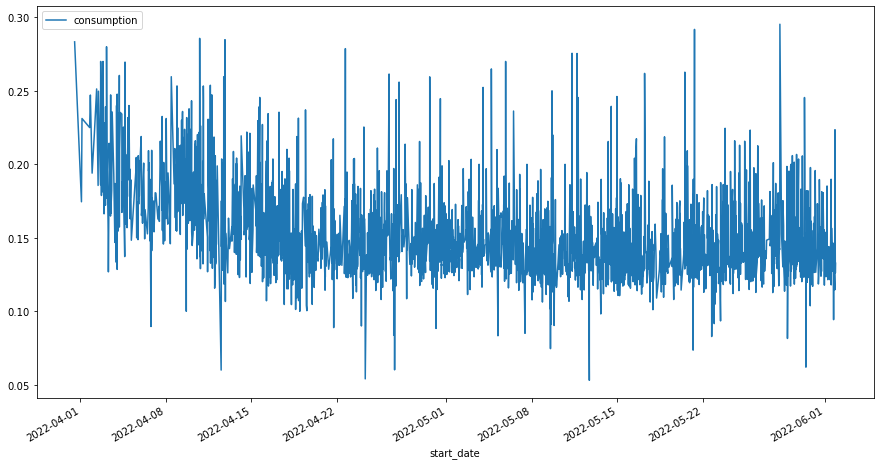

In [46]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05].plot(x='start_date', y='consumption', figsize=(15, 8))

<AxesSubplot:xlabel='start_date'>

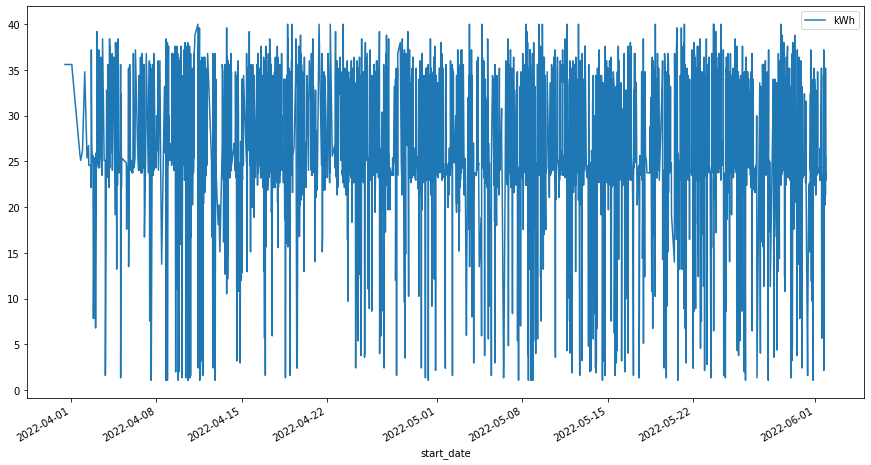

In [47]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05].plot(x='start_date', y='kWh', figsize=(15, 8))

In [ ]:
sessions

In [51]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05]['kWh'].describe()

count    3426.000000
mean       25.884974
std         7.705457
min         1.080000
25%        23.490000
50%        24.840000
75%        32.800000
max        40.000000
Name: kWh, dtype: float64

In [52]:
other_df = sessions_df[sessions_df['kWh']<5]

In [53]:
other_df

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,month,day,created_id,last_mileage,last_plate,distance,kWh,kWh_used,battery_used,consumption
41,FB-797-JS,ZOE,2022-04-07 17:58:18,2022-04-07 18:06:09,90.0,100.0,"22 Rue Yves Kermen, 92100 Boulogne-Billancourt...",florian arnault,13699.0,10.0,Avril,97,FB-797-JSflorian arnault97,16471.0,FB-802-ZW,0.0,4.00,4.00,10.0,inf
59,FB-226-HW,ZOE,2022-04-03 20:00:04,2022-04-03 22:09:55,14.0,18.0,"12 Rue Darmesteter, 75013 Paris, France",Client,19673.0,4.0,Avril,93,FB-226-HWClient93,19489.0,FB-226-HW,184.0,1.60,34.40,86.0,0.186957
88,FZ-804-RF,Spring,2022-05-08 20:34:00,2022-05-09 08:06:00,26.0,30.0,"31 Rue des Ardennes, 75019 Paris, France",Client,5849.0,4.0,Mai,128,FZ-804-RFClient128,5703.0,FZ-804-RF,146.0,1.08,19.98,74.0,0.136849
95,FZ-804-RF,Spring,2022-05-20 03:12:00,2022-05-20 03:31:00,93.0,99.0,"54 Rue du Moulin des Prés, 75013 Paris, France",Joseph Pagal,6056.0,6.0,Mai,140,FZ-804-RFJoseph Pagal140,6056.0,FZ-804-RF,0.0,1.62,0.00,0.0,NaN
168,GD-791-TQ,Spring,2022-05-26 07:05:00,2022-05-26 06:35:00,15.0,19.0,"1 Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,2078.0,4.0,Mai,146,GD-791-TQVan Huy NGUYEN146,1909.0,GD-791-TQ,169.0,1.08,22.95,85.0,0.135799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,GB-864-JX,Spring,2022-05-19 19:18:00,2022-05-19 19:26:00,11.0,16.0,"12/14 Rue Charles Fourier, 75013 Paris, France",Seraphin TAM,4015.0,5.0,Mai,139,GB-864-JXSeraphin TAM139,3851.0,GB-864-JX,164.0,1.35,24.03,89.0,0.146524
8570,GB-866-JX,Spring,2022-05-21 10:08:00,2022-05-21 10:25:00,6.0,17.0,"19 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Romain Sannajust,754.0,11.0,Mai,141,GB-866-JXRomain Sannajust141,613.0,GB-866-JX,141.0,2.97,22.41,83.0,0.158936
8576,GB-866-JX,Spring,2022-05-27 19:49:00,2022-05-28 02:37:00,83.0,100.0,"40 All. des Frères Voisin, 75015 Paris, France",Madil Berkani,923.0,17.0,Mai,147,GB-866-JXMadil Berkani147,923.0,GB-866-JX,0.0,4.59,0.00,0.0,NaN
8599,FZ-883-RF,Spring,2022-05-09 09:39:00,2022-05-09 16:09:00,96.0,100.0,"43 Rue Olivier Métra, 75020 Paris, France",Abou DIABY,3294.0,4.0,Mai,129,FZ-883-RFAbou DIABY129,3294.0,FZ-883-RF,0.0,1.08,-0.27,-1.0,-inf


In [39]:
plate = 'FZ-804-RF'
sessions_df[sessions_df['plate_number']==plate]

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,month,day,created_id,last_mileage,last_plate,distance,kWh,kWh_used,battery_used,consumption
75,FZ-804-RF,Spring,2022-04-07 23:38:59,2022-04-08 01:21:37,2.0,100.0,"52 Rue du Moulinet, 75013 Paris, France",Djegui Toure,4713.0,98.0,Avril,97,FZ-804-RFDjegui Toure97,20714.0,FB-226-HW,0.0,26.46,23.76,88.0,inf
80,FZ-804-RF,Spring,2022-04-14 00:02:36,2022-04-14 01:40:22,6.0,95.0,"6 Rue de lEssai, 75005 Paris, France",Alexandre Makunga,4892.0,89.0,Avril,104,FZ-804-RFAlexandre Makunga104,4713.0,FZ-804-RF,179.0,24.03,25.38,94.0,0.141788
81,FZ-804-RF,Spring,2022-04-16 18:47:11,2022-04-17 15:18:00,11.0,98.0,"3 Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,5055.0,87.0,Avril,106,FZ-804-RFVan Huy NGUYEN106,4892.0,FZ-804-RF,163.0,23.49,22.68,84.0,0.139141
83,FZ-804-RF,Spring,2022-04-21 17:08:49,2022-04-21 19:06:53,19.0,100.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",luc talbot,5198.0,81.0,Avril,111,FZ-804-RFluc talbot111,5055.0,FZ-804-RF,143.0,21.87,21.33,79.0,0.149161
84,FZ-804-RF,Spring,2022-04-25 23:40:02,2022-04-27 11:06:00,10.0,100.0,"6 Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,5370.0,90.0,Avril,115,FZ-804-RFVan Huy NGUYEN115,5198.0,FZ-804-RF,172.0,24.30,24.30,90.0,0.141279
85,FZ-804-RF,Spring,2022-04-30 05:39:00,2022-04-30 11:12:00,12.0,100.0,"6 Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,5540.0,88.0,Avril,120,FZ-804-RFVan Huy NGUYEN120,5370.0,FZ-804-RF,170.0,23.76,23.76,88.0,0.139765
87,FZ-804-RF,Spring,2022-05-03 15:30:00,2022-05-03 16:54:00,12.0,100.0,"3 Rue Censier, 75005 Paris, France",Herve BWASI-LUBAYA,5703.0,88.0,Mai,123,FZ-804-RFHerve BWASI-LUBAYA123,5540.0,FZ-804-RF,163.0,23.76,23.76,88.0,0.145767
88,FZ-804-RF,Spring,2022-05-08 20:34:00,2022-05-09 08:06:00,26.0,30.0,"31 Rue des Ardennes, 75019 Paris, France",Client,5849.0,4.0,Mai,128,FZ-804-RFClient128,5703.0,FZ-804-RF,146.0,1.08,19.98,74.0,0.136849
90,FZ-804-RF,Spring,2022-05-12 11:55:00,2022-05-13 14:00:00,12.0,100.0,"13 Rue Heinrich, 92100 Boulogne-Billancourt, F...",Zity Paris 1,5874.0,88.0,Mai,132,FZ-804-RFZity Paris 1132,5849.0,FZ-804-RF,25.0,23.76,4.86,18.0,0.194400
93,FZ-804-RF,Spring,2022-05-19 23:05:00,2022-05-20 02:10:00,12.0,68.0,"54 Rue du Moulin des Prés, 75013 Paris, France",Joseph Pagal,6056.0,56.0,Mai,139,FZ-804-RFJoseph Pagal139,5874.0,FZ-804-RF,182.0,15.12,23.76,88.0,0.130549


In [40]:
dataframe = df[df['plate_number']==plate].tail(60)
dataframe

,plate_number,driver,start_adress,end_adress,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,battery_level_at_start,battery_level_at_end,car_model,booking_id,start_date_time,end_date_time,charging,delta,month
61330,FZ-804-RF,Joseph Pagal,"6 Rue Christine de Pisan, 75017 Paris, France","126 Rue de Saussure, 75017 Paris, France",5540.0,5541.0,4/30/2022 11:59:00 AM,4/30/2022 11:12:00 AM,100,100,Spring,RZTY9104106,2022-04-30 11:12:00,2022-04-30 11:59:00,False,0,Avril
14786,FZ-804-RF,Client,"126 Rue de Saussure, 75017 Paris, France","8 Rue Brochant, 75017 Paris, France",5541.0,5637.0,4/30/2022 7:22:00 PM,4/30/2022 2:23:00 PM,100,56,Spring,RZTY9105174,2022-04-30 14:23:00,2022-04-30 19:22:00,False,-44,Avril
950,FZ-804-RF,Client,"8 Rue Brochant, 75017 Paris, France","48 Av. Simon Bolivar, 75019 Paris, France",5637.0,5643.0,4/30/2022 8:31:00 PM,4/30/2022 7:53:00 PM,56,53,Spring,RZTY9107004,2022-04-30 19:53:00,2022-04-30 20:31:00,False,-3,Avril
43053,FZ-804-RF,Client,"48 Av. Simon Bolivar, 75019 Paris, France","89 Rue Legendre, 75017 Paris, France",5643.0,5650.0,4/30/2022 10:52:00 PM,4/30/2022 10:12:00 PM,53,49,Spring,RZTY9107805,2022-04-30 22:12:00,2022-04-30 22:52:00,False,-4,Avril
44090,FZ-804-RF,Client,"89 Rue Legendre, 75017 Paris, France","89 Rue Legendre, 75017 Paris, France",5650.0,5650.0,5/1/2022 10:56:00 AM,5/1/2022 10:37:00 AM,49,49,Spring,RZTY9109549,2022-05-01 10:37:00,2022-05-01 10:56:00,False,0,Mai
42286,FZ-804-RF,Client,"89 Rue Legendre, 75017 Paris, France","149 Av. de Wagram, 75017 Paris, France",5650.0,5654.0,5/1/2022 11:15:00 AM,5/1/2022 10:56:00 AM,49,45,Spring,RZTY9109621,2022-05-01 10:56:00,2022-05-01 11:15:00,False,-4,Mai
53380,FZ-804-RF,Client,"149 Av. de Wagram, 75017 Paris, France","126 Av. de Suffren, 75015 Paris, France",5654.0,5659.0,5/1/2022 4:11:00 PM,5/1/2022 3:51:00 PM,45,43,Spring,RZTY9110940,2022-05-01 15:51:00,2022-05-01 16:11:00,False,-2,Mai
42480,FZ-804-RF,Client,"126 Av. de Suffren, 75015 Paris, France","Avenue Bartholomé, 75015 Paris, France",5659.0,5663.0,5/1/2022 5:04:00 PM,5/1/2022 4:45:00 PM,43,40,Spring,RZTY9111199,2022-05-01 16:45:00,2022-05-01 17:04:00,False,-3,Mai
41938,FZ-804-RF,Client,"7 Rue Monsigny, 75002 Paris, France","80 Rue de Dantzig, 75015 Paris, France",5670.0,5678.0,5/1/2022 10:41:00 PM,5/1/2022 10:14:00 PM,36,31,Spring,RZTY9112866,2022-05-01 22:14:00,2022-05-01 22:41:00,False,-5,Mai
34541,FZ-804-RF,Client,"80 Rue de Dantzig, 75015 Paris, France","80 Rue de Dantzig, 75015 Paris, France",5678.0,5678.0,5/1/2022 11:25:00 PM,5/1/2022 11:09:00 PM,31,31,Spring,RZTY9113083,2022-05-01 23:09:00,2022-05-01 23:25:00,False,0,Mai


In [41]:
dataframe.reset_index(drop=True, inplace=True)
plate = dataframe.loc[0, 'plate_number']
model = dataframe.loc[0, 'car_model']
dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
for index in range(len(dataframe)):
    if dataframe.loc[index, 'battery_drop']/(dataframe.loc[index, 'delta_hours']+1) > 5:
            dataframe.loc[index, 'battery_level_at_start'] = dataframe.loc[index, 'last_end_battery']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']
    if (dataframe.loc[index, 'battery_level_at_start'] - dataframe.loc[index, 'battery_level_at_end'])/(dataframe.loc[index, 'duration']+1)>30:
            dataframe.loc[index, 'battery_level_at_end'] = dataframe.loc[index, 'battery_level_at_start']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']


In [865]:
dataframe

,plate_number,driver,start_adress,end_adress,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,battery_level_at_start,battery_level_at_end,...,start_date_time,end_date_time,charging,delta,month,last_end_battery,last_end_date,delta_hours,duration,battery_drop
0,FB-802-ZW,Client,"16 Bd des Batignolles, 75017 Paris, France","19 Av. André Morizet, 92100 Boulogne-Billancou...",14440.0,14452.0,3/30/2022 12:36:52 AM,3/30/2022 12:04:53 AM,79,73,...,2022-03-30 00:04:53,2022-03-30 00:36:52,False,-6,Mars,NaN,NaT,NaN,0.0,NaN
1,FB-802-ZW,Client,"19 Av. André Morizet, 92100 Boulogne-Billancou...","10 Rue Auguste Chabrières, 75015 Paris, France",14452.0,14457.0,3/30/2022 9:17:10 AM,3/30/2022 8:50:22 AM,73,71,...,2022-03-30 08:50:22,2022-03-30 09:17:10,False,-2,Mars,73.0,2022-03-30 00:36:52,8.0,0.0,0.0
2,FB-802-ZW,Client,"10 Rue Auguste Chabrières, 75015 Paris, France","131 Bd Jean Jaurès, 92100 Boulogne-Billancourt...",14457.0,14461.0,3/30/2022 1:37:19 PM,3/30/2022 1:17:26 PM,71,69,...,2022-03-30 13:17:26,2022-03-30 13:37:19,False,-2,Mars,71.0,2022-03-30 09:17:10,4.0,0.0,0.0
3,FB-802-ZW,Client,"131 Bd Jean Jaurès, 92100 Boulogne-Billancourt...","11 Rue Victor Griffuelhes, 92100 Boulogne-Bill...",14461.0,14461.0,3/30/2022 1:50:11 PM,3/30/2022 1:39:16 PM,69,69,...,2022-03-30 13:39:16,2022-03-30 13:50:11,False,0,Mars,69.0,2022-03-30 13:37:19,0.0,0.0,0.0
4,FB-802-ZW,Client,"11 Rue Victor Griffuelhes, 92100 Boulogne-Bill...","92 Rue dAguesseau, 92100 Boulogne-Billancourt,...",14461.0,14463.0,3/30/2022 2:12:33 PM,3/30/2022 1:53:56 PM,69,68,...,2022-03-30 13:53:56,2022-03-30 14:12:33,False,-1,Mars,69.0,2022-03-30 13:50:11,0.0,0.0,0.0
5,FB-802-ZW,Client,"92 Rue dAguesseau, 92100 Boulogne-Billancourt,...","58 Rue de Meudon, 92100 Boulogne-Billancourt, ...",14463.0,14464.0,3/30/2022 3:31:07 PM,3/30/2022 3:09:25 PM,68,68,...,2022-03-30 15:09:25,2022-03-30 15:31:07,False,0,Mars,68.0,2022-03-30 14:12:33,0.0,0.0,0.0
6,FB-802-ZW,Client,"58 Rue de Meudon, 92100 Boulogne-Billancourt, ...","67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...",14464.0,14466.0,3/30/2022 3:46:30 PM,3/30/2022 3:36:07 PM,68,67,...,2022-03-30 15:36:07,2022-03-30 15:46:30,False,-1,Mars,68.0,2022-03-30 15:31:07,0.0,0.0,0.0
7,FB-802-ZW,Client,"67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...","67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...",14466.0,14466.0,3/30/2022 4:31:28 PM,3/30/2022 4:28:13 PM,67,67,...,2022-03-30 16:28:13,2022-03-30 16:31:28,False,0,Mars,67.0,2022-03-30 15:46:30,0.0,0.0,0.0
8,FB-802-ZW,Client,"67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...","15 Rue Lacroix, 75017 Paris, France",14466.0,14500.0,3/30/2022 10:01:09 PM,3/30/2022 8:10:53 PM,67,52,...,2022-03-30 20:10:53,2022-03-30 22:01:09,False,-15,Mars,67.0,2022-03-30 16:31:28,3.0,1.0,0.0
9,FB-802-ZW,Client,"15 Rue Lacroix, 75017 Paris, France","11 Rue Olivier Métra, 75020 Paris, France",14500.0,14508.0,3/31/2022 8:51:09 AM,3/31/2022 7:57:03 AM,52,46,...,2022-03-31 07:57:03,2022-03-31 08:51:09,False,-6,Mars,52.0,2022-03-30 22:01:09,9.0,0.0,0.0


In [866]:
dataframe.reset_index(drop=True, inplace=True)
dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
dataframe['was_charging']=(dataframe['battery_level_at_start']-dataframe['last_end_battery']>0)
dataframe["charging"] = (dataframe['battery_level_at_end']-dataframe['battery_level_at_start']>1)
charging_sessions = []
index = 0
current_start = 0
start = ""
start_battery = 0
current_last = 0
open_booking = False
while index < len(dataframe) :
    if open_booking: # car was charging
        if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
            open_booking = False
            if dataframe.loc[index, 'was_charging']:
                charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
            else :
                charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index-1, 'start_date_time'], start_battery, dataframe.loc[current_last, 'battery_level_at_end'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
        else : # car is still charging
                current_last = index
    else : # car wasn't charging
        if dataframe.loc[index, 'was_charging']: # the car was charged since last booking
            open_booking = True
            current_start = index-1
            start = 'end_'
            current_last = index
            start_battery = dataframe.loc[current_start, 'battery_level_at_end']
            if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                open_booking = False
                charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
        else :
            if dataframe.loc[index, 'charging']:
                open_booking = True
                current_start = index
                start = "start_"
                current_last = index
                start_battery = dataframe.loc[index, 'battery_level_at_start']
        index += 1

In [867]:
dataframe

,plate_number,driver,start_adress,end_adress,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,battery_level_at_start,battery_level_at_end,...,end_date_time,charging,delta,month,last_end_battery,last_end_date,delta_hours,duration,battery_drop,was_charging
0,FB-802-ZW,Client,"16 Bd des Batignolles, 75017 Paris, France","19 Av. André Morizet, 92100 Boulogne-Billancou...",14440.0,14452.0,3/30/2022 12:36:52 AM,3/30/2022 12:04:53 AM,79,73,...,2022-03-30 00:36:52,False,-6,Mars,NaN,NaT,NaN,0.0,NaN,False
1,FB-802-ZW,Client,"19 Av. André Morizet, 92100 Boulogne-Billancou...","10 Rue Auguste Chabrières, 75015 Paris, France",14452.0,14457.0,3/30/2022 9:17:10 AM,3/30/2022 8:50:22 AM,73,71,...,2022-03-30 09:17:10,False,-2,Mars,73.0,2022-03-30 00:36:52,8.0,0.0,0.0,False
2,FB-802-ZW,Client,"10 Rue Auguste Chabrières, 75015 Paris, France","131 Bd Jean Jaurès, 92100 Boulogne-Billancourt...",14457.0,14461.0,3/30/2022 1:37:19 PM,3/30/2022 1:17:26 PM,71,69,...,2022-03-30 13:37:19,False,-2,Mars,71.0,2022-03-30 09:17:10,4.0,0.0,0.0,False
3,FB-802-ZW,Client,"131 Bd Jean Jaurès, 92100 Boulogne-Billancourt...","11 Rue Victor Griffuelhes, 92100 Boulogne-Bill...",14461.0,14461.0,3/30/2022 1:50:11 PM,3/30/2022 1:39:16 PM,69,69,...,2022-03-30 13:50:11,False,0,Mars,69.0,2022-03-30 13:37:19,0.0,0.0,0.0,False
4,FB-802-ZW,Client,"11 Rue Victor Griffuelhes, 92100 Boulogne-Bill...","92 Rue dAguesseau, 92100 Boulogne-Billancourt,...",14461.0,14463.0,3/30/2022 2:12:33 PM,3/30/2022 1:53:56 PM,69,68,...,2022-03-30 14:12:33,False,-1,Mars,69.0,2022-03-30 13:50:11,0.0,0.0,0.0,False
5,FB-802-ZW,Client,"92 Rue dAguesseau, 92100 Boulogne-Billancourt,...","58 Rue de Meudon, 92100 Boulogne-Billancourt, ...",14463.0,14464.0,3/30/2022 3:31:07 PM,3/30/2022 3:09:25 PM,68,68,...,2022-03-30 15:31:07,False,0,Mars,68.0,2022-03-30 14:12:33,0.0,0.0,0.0,False
6,FB-802-ZW,Client,"58 Rue de Meudon, 92100 Boulogne-Billancourt, ...","67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...",14464.0,14466.0,3/30/2022 3:46:30 PM,3/30/2022 3:36:07 PM,68,67,...,2022-03-30 15:46:30,False,-1,Mars,68.0,2022-03-30 15:31:07,0.0,0.0,0.0,False
7,FB-802-ZW,Client,"67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...","67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...",14466.0,14466.0,3/30/2022 4:31:28 PM,3/30/2022 4:28:13 PM,67,67,...,2022-03-30 16:31:28,False,0,Mars,67.0,2022-03-30 15:46:30,0.0,0.0,0.0,False
8,FB-802-ZW,Client,"67 Bd Jean Jaurès, 92100 Boulogne-Billancourt,...","15 Rue Lacroix, 75017 Paris, France",14466.0,14500.0,3/30/2022 10:01:09 PM,3/30/2022 8:10:53 PM,67,52,...,2022-03-30 22:01:09,False,-15,Mars,67.0,2022-03-30 16:31:28,3.0,1.0,0.0,False
9,FB-802-ZW,Client,"15 Rue Lacroix, 75017 Paris, France","11 Rue Olivier Métra, 75020 Paris, France",14500.0,14508.0,3/31/2022 8:51:09 AM,3/31/2022 7:57:03 AM,52,46,...,2022-03-31 08:51:09,False,-6,Mars,52.0,2022-03-30 22:01:09,9.0,0.0,0.0,False


In [868]:
pd.DataFrame(charging_sessions).head(10)

,0,1,2,3,4,5,6,7,8
0,FB-802-ZW,ZOE,2022-04-03 03:21:55,2022-04-03 07:31:34,7,100,"62 Rue du Moulin des Prés, 75013 Paris, France",Van Huy NGUYEN,14583.0
1,FB-802-ZW,ZOE,2022-04-08 03:48:34,2022-04-08 09:58:37,10,100,"4Z Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,14809.0
2,FB-802-ZW,ZOE,2022-04-09 01:12:49,2022-04-09 19:42:05,97,98,"98 Bd Victor Hugo, 92110 Clichy, France",Van Huy NGUYEN,14816.0


In [869]:
sessions_df[sessions_df['plate_number']=='FB-226-HW'].head(10)

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,month,day,created_id,last_mileage,last_plate,distance,kWh,kWh_used,battery_used,consumption
58,FB-226-HW,ZOE,2022-03-30 03:00:52,2022-03-30 05:54:45,12.0,100.0,"62 Rue du Moulin des Prés, 75013 Paris, France",Solal Cuinet,19489.0,88.0,Mars,89,FB-226-HWSolal Cuinet89,15219.0,FB-797-JS,0.0,35.2,35.2,88.0,inf
59,FB-226-HW,ZOE,2022-04-03 20:00:04,2022-04-03 22:09:55,14.0,18.0,"12 Rue Darmesteter, 75013 Paris, France",Client,19673.0,4.0,Avril,93,FB-226-HWClient93,19489.0,FB-226-HW,184.0,1.6,34.4,86.0,0.186957
60,FB-226-HW,ZOE,2022-04-03 22:31:44,2022-04-04 00:28:13,17.0,99.0,"54 Rue du Moulin des Prés, 75013 Paris, France",Ronald Rigah Jonathan,19676.0,82.0,Avril,93,FB-226-HWRonald Rigah Jonathan93,19673.0,FB-226-HW,3.0,32.8,0.4,1.0,0.133333
63,FB-226-HW,ZOE,2022-04-13 22:47:22,2022-04-14 00:59:52,10.0,97.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Paul Millet,19878.0,87.0,Avril,103,FB-226-HWPaul Millet103,19676.0,FB-226-HW,202.0,34.8,35.6,89.0,0.176238
65,FB-226-HW,ZOE,2022-04-24 02:27:56,2022-04-24 14:14:53,12.0,100.0,"62 Rue du Moulin des Prés, 75013 Paris, France",Djegui Toure,20088.0,88.0,Avril,114,FB-226-HWDjegui Toure114,19878.0,FB-226-HW,210.0,35.2,34.0,85.0,0.161905
67,FB-226-HW,ZOE,2022-04-28 08:01:00,2022-04-28 11:07:00,1.0,100.0,"36 Rue Olivier Métra, 75020 Paris, France",Mohamadou Niakate,20204.0,99.0,Avril,118,FB-226-HWMohamadou Niakate118,20088.0,FB-226-HW,116.0,39.6,39.6,99.0,0.341379
69,FB-226-HW,ZOE,2022-05-06 15:34:00,2022-05-06 17:50:00,10.0,100.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Herve BWASI-LUBAYA,20477.0,90.0,Mai,126,FB-226-HWHerve BWASI-LUBAYA126,20204.0,FB-226-HW,273.0,36.0,36.0,90.0,0.131868
72,FB-226-HW,ZOE,2022-05-16 08:57:00,2022-05-16 09:02:00,16.0,90.0,"4Z Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,20714.0,74.0,Mai,136,FB-226-HWVan Huy NGUYEN136,20477.0,FB-226-HW,237.0,29.6,33.6,84.0,0.141772


In [940]:
sessions_df['driver'].value_counts()

Van Huy NGUYEN      608
Madil Berkani       347
Moke N Kazi         332
Mathias Riguet      264
Client              238
                   ... 
Ludivine Duhamel      1
RRG Courbevoie        1
Jordi Carbonell       1
RRG Trappes           1
mohamed tersime       1
Name: driver, Length: 75, dtype: int64

In [54]:
sessions_df[sessions_df['model']=='ZOE']['kWh'].describe()

count    1482.000000
mean       31.404318
std         8.541450
min         1.600000
25%        31.600000
50%        34.400000
75%        36.000000
max        40.000000
Name: kWh, dtype: float64

In [55]:
sessions_df[sessions_df['driver']=="Client"]['kWh'].sum()

count    2805.000000
mean       21.406717
std         6.412219
min         1.080000
25%        22.410000
50%        23.760000
75%        24.840000
max        27.000000
Name: kWh, dtype: float64

In [942]:
sessions_df['kWh']=pd.to_numeric(sessions_df['kWh'])

In [943]:
sessions_df['kWh_used']=pd.to_numeric(sessions_df['kWh_used'])

In [75]:
sessions_df[sessions_df['consumption']<0.20][sessions_df['consumption']>0.10]

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,month,day,created_id,last_mileage,last_plate,distance,kWh,kWh_used,battery_used,consumption
8,FB-386-YK,ZOE,2022-04-13 17:31:00,2022-04-13 19:55:24,17.0,100.0,"26 Bd des Frères Voisin, 75015 Paris, France",Madil Berkani,16107.0,83.0,Avril,103,FB-386-YKMadil Berkani103,15945.0,FB-386-YK,162.0,33.20,27.20,68.0,0.167901
9,FB-386-YK,ZOE,2022-04-18 16:39:24,2022-04-19 19:16:26,14.0,100.0,"12 Rue de lÉcole de Médecine, 75006 Paris, France",Alexandre Makunga,16339.0,86.0,Avril,108,FB-386-YKAlexandre Makunga108,16107.0,FB-386-YK,232.0,34.40,34.40,86.0,0.148276
10,FB-386-YK,ZOE,2022-04-24 19:18:29,2022-04-25 17:40:24,14.0,100.0,"40ter Rue Olivier Métra, 75020 Paris, France",Daniel Da Silva Meneses Campos,16579.0,86.0,Avril,114,FB-386-YKDaniel Da Silva Meneses Campos114,16339.0,FB-386-YK,240.0,34.40,34.40,86.0,0.143333
17,FB-386-YK,ZOE,2022-05-09 16:52:00,2022-05-16 12:18:00,16.0,99.0,"79 Pl. Saint-Jacques, 75014 Paris, France",Zity Paris 1,16784.0,83.0,Mai,129,FB-386-YKZity Paris 1129,16579.0,FB-386-YK,205.0,33.20,33.60,84.0,0.163902
18,FB-386-YK,ZOE,2022-05-18 01:27:00,2022-05-18 04:08:00,13.0,100.0,"37 Rue Olivier Métra, 75020 Paris, France",Joseph Pagal,17024.0,87.0,Mai,138,FB-386-YKJoseph Pagal138,16784.0,FB-386-YK,240.0,34.80,34.40,86.0,0.143333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,GB-945-JX,Spring,2022-05-09 22:35:00,2022-05-10 00:18:00,12.0,100.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Jean Marc Evan Randriamahazomanana,1698.0,88.0,Mai,129,GB-945-JXJean Marc Evan Randriamahazomanana 129,1564.0,GB-945-JX,134.0,23.76,17.82,66.0,0.132985
8613,GB-945-JX,Spring,2022-05-15 13:05:00,2022-05-15 14:02:00,11.0,34.0,"12 Rue Censier, 75005 Paris, France",Alexandre Makunga,1902.0,23.0,Mai,135,GB-945-JXAlexandre Makunga135,1698.0,GB-945-JX,204.0,6.21,24.03,89.0,0.117794
8617,GB-945-JX,Spring,2022-05-23 12:42:00,2022-05-23 14:14:00,11.0,100.0,"6 Rue Santeuil, 75005 Paris, France",Client,2087.0,89.0,Mai,143,GB-945-JXClient143,1902.0,GB-945-JX,185.0,24.03,24.03,89.0,0.129892
8618,GB-945-JX,Spring,2022-05-29 00:59:00,2022-05-29 02:25:00,6.0,100.0,"4 Rue Christine de Pisan, 75017 Paris, France",hicham boulahtit,2276.0,94.0,Mai,149,GB-945-JXhicham boulahtit149,2087.0,GB-945-JX,189.0,25.38,25.38,94.0,0.134286


In [67]:
sessions_df['consumption'].value_counts()

 inf         516
-inf          84
 0.135000     33
-0.000000     25
 0.133333     12
            ... 
 0.173444      1
 0.164912      1
 0.113496      1
 0.162679      1
 0.129685      1
Name: consumption, Length: 2142, dtype: int64

In [944]:
sessions_df.to_csv("charging_sessions2.csv")